# Przemysław Kaleta: Spectral clustering

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import scale

# Importing metrics:
from sklearn.metrics import fowlkes_mallows_score as fms
from sklearn.metrics import adjusted_mutual_info_score as amis
from sklearn.metrics import adjusted_rand_score as ars

# Importing clustering algorithms
from spectral import spectral_clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree
import genieclust
from sklearn.cluster import KMeans, DBSCAN, MeanShift

In [69]:
def score_tuple(Y, Y_pred):
    # average method arithmetic in amis because warnings are showed otherwise
    return fms(Y, Y_pred), amis(Y, Y_pred, average_method='arithmetic'), ars(Y, Y_pred)

def create_result_df():
    result = pd.DataFrame({"benchmark":[], 
                           "dataset":[], 
                           "algorithm": [], 
                           "n_clusters":[],
                           "FM": [], 
                           "AM": [], 
                           "AR": []
                          })
    return result 

def test_linkage(X, Y, k=2, method='single'):
    Y_pred = cut_tree(linkage(X, method=method), n_clusters=k)
    Y_pred = np.squeeze(Y_pred)
    return score_tuple(Y, Y_pred)

# My apologies for repeating some code

def test_genie(X, Y, k=2):
    g = genieclust.genie.Genie(n_clusters=2)
    Y_pred = g.fit_predict(X)
    return score_tuple(Y, Y_pred)

def test_kmeans(X, Y, k=2):
    kmeans = KMeans(n_clusters=k)
    Y_pred = kmeans.fit_predict(X)
    return score_tuple(Y, Y_pred)

def test_dbscan(X, Y, k=2, **kwargs):
    dbscan = DBSCAN(**kwargs)
    Y_pred = dbscan.fit_predict(X)
    return score_tuple(Y, Y_pred)

def test_meanshift(X, Y, k=2):
    meanshift = MeanShift()
    Y_pred = meanshift.fit_predict(X)
    return score_tuple(Y, Y_pred)

def append_result(result, benchmark, dataset, algorithm, n_clusters, fms, amis, ars):
    new_row = pd.DataFrame({"benchmark": [benchmark],
                      "dataset": [dataset],
                      "algorithm": [algorithm],
                      "n_clusters": [n_clusters],
                      "FM": [fms],
                      "AM": [amis],
                      "AR": [ars]
                  })
    result = result.append(new_row)
    return result

def plot_2d_vectors(X, Y, title=None):
    """Plots 2D vectors represented as a matrix of 2d vectors with different colors for different classes"""
    plt.scatter(X[:, 0], X[:, 1], c=Y)
    if title:
        plt.title(title)
    plt.show()

In [70]:
def report(benchmark, dataset):
    label_ending = ".labels0.gz"
    matrix_ending = ".data.gz"
    matrix_path = os.path.join("..", "benchmarks", benchmark, dataset + matrix_ending)
    labels_path = os.path.join("..", "benchmarks", benchmark, dataset + label_ending)
    result = create_result_df()
    
    X = np.loadtxt(matrix_path, ndmin=2)
    Y = np.loadtxt(labels_path, dtype=np.int)
    true_n_clusters = len(np.unique(Y))
    ks = [2, 3, 4, 5] + [true_n_clusters] # testing also on true number of clusters (it is debatable wheter it's fair)
    for k in set(ks):
        # Testing linkage methods
        methods = ['single', 'average', 'weighted', 'centroid', 'median', 'ward']
        for method in methods:
            fms, amis, ars = test_linkage(X, Y, k, method=method)
            result = append_result(result, benchmark, dataset, "_".join(["linkage", method]), k, fms, amis, ars)
            
        # Testing genie 
        fms, amis, ars = test_genie(X, Y, k)
        result = append_result(result, benchmark, dataset, "genie", k, fms, amis, ars)
        
        # Testing kmeans
        result = append_result(result, benchmark, dataset, "kmeans", k, *test_kmeans(X, Y, k))
        
        # Testing dbscan
        result = append_result(result, benchmark, dataset, "dbscan", k, *test_dbscan(X, Y))
        
        # Testing meanshift
        result = append_result(result, benchmark, dataset, "meanshift", k, *test_meanshift(X, Y))
        
    return result.reset_index(drop=True)

## Wielki test wszystkich algorytmów
(oprócz spectral_clustering, który działa zbyt wolno)

In [71]:
benchmarks = ['fcps', 'sipu', 'wut', 'other', 'graves']

for benchmark in benchmarks:
    result = create_result_df()
    
    main_path = os.path.join("..", "benchmarks", benchmark)
    datasets = os.listdir(main_path)
    for file in datasets:
        if "txt" in file:
            file_name = file.split(".")
            dataset = file_name[0]
            print("Processing {}/{}".format(benchmark, dataset))
            result = result.append(report(benchmark, dataset))

Processing fcps/engytime
Processing fcps/twodiamonds
Processing fcps/chainlink
Processing fcps/target
Processing fcps/hepta
Processing fcps/atom
Processing fcps/lsun
Processing fcps/tetra
Processing fcps/wingnut
Processing sipu/s3
Processing sipu/flame
Processing sipu/s4
Processing sipu/s2
Processing sipu/compound
Processing sipu/jain
Processing sipu/d31
Processing sipu/a2
Processing sipu/aggregation
Processing sipu/s1


KeyboardInterrupt: 

In [217]:
result.to_csv("result_linkage_genie.csv")

In [219]:
result.head()

,benchmark,dataset,algorithm,n_clusters,FM,AM,AR
0,graves,fuzzyx,linkage_single,2.0,0.448099,-0.000048,-0.000075
0,graves,fuzzyx,linkage_average,2.0,0.474544,0.180291,0.101385
0,graves,fuzzyx,linkage_weighted,2.0,0.596283,0.366460,0.346222
0,graves,fuzzyx,linkage_centroid,2.0,0.454635,0.148687,0.070490
0,graves,fuzzyx,linkage_median,2.0,0.432453,0.080034,0.019766


In [234]:
result.groupby("algorithm")["FM"].mean().reset_index().sort_values("FM", ascending=False).reset_index(drop=True)

,algorithm,FM
0,linkage_single,0.755954
1,linkage_average,0.667687
2,genie,0.660359
3,linkage_ward,0.660359
4,linkage_centroid,0.659359
5,linkage_weighted,0.634308
6,linkage_median,0.616610


## Testy algorytmu spectral clustering na wybranych danych

In [63]:
benchmark, dataset = "sipu", "a1"
label_ending = ".labels0.gz"
matrix_ending = ".data.gz"
matrix_path = os.path.join("..", "benchmarks", benchmark, dataset + matrix_ending)
labels_path = os.path.join("..", "benchmarks", benchmark, dataset + label_ending)
result = create_result_df()

X = np.loadtxt(matrix_path, ndmin=2)
Y = np.loadtxt(labels_path, dtype=np.int)

In [10]:
Y_pred = spectral_clustering(X, 2, 2)

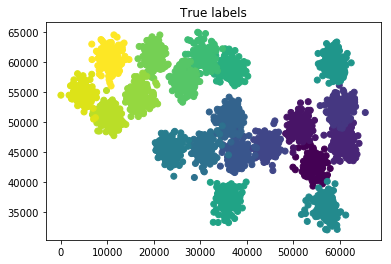

In [12]:
plot_2d_vectors(X, Y, "True labels")

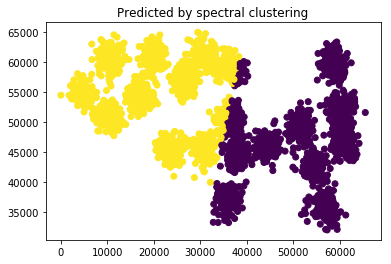

In [13]:
plot_2d_vectors(X, Y_pred, "Predicted by spectral clustering")

Małe oszustwo: sprawdźmy ile jest klas w wyjściowym zbiorze i zbadajmy skupienia naszym algorytmem dla takiego parametru k.

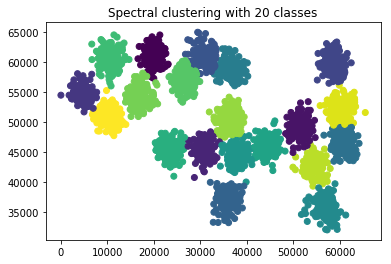

In [64]:
n_clusters = len(np.unique(Y))
Y_pred = spectral_clustering(X, n_clusters, 2)
plot_2d_vectors(X, Y_pred, "Spectral clustering with {} classes".format(n_clusters))

Widzimy, że algorytm sprawuje się całkiem nieźle i dobrze wyłapuje wyraźnie widoczne skupienia punktów
w przestrzeni R^2.

Dla pewności jeszcze wyniki zwracane przez nasze miary:

In [66]:
score_tuple(Y, Y_pred)

(0.9680171410185083, 0.9732559391557366, 0.966344710501798)

##### Jest pięknie.

## DBSCAN

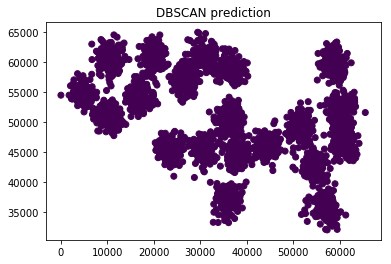

In [27]:
dbscan = DBSCAN()
Y_pred = dbscan.fit_predict(X)
plot_2d_vectors(X, Y_pred, "DBSCAN prediction")

DBSCAN za pierwszym razem nie sprawuje się najlepiej. Spróbujmy popatrzeć, co można by w nim poprawić.

Z dokumentacji podobno ma być: "Good for data which contains clusters of similar density". 

In [45]:
X_std = scale(X)

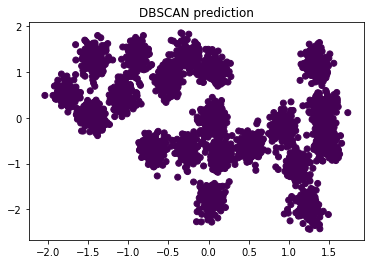

In [50]:
dbscan = DBSCAN(eps=0.48, metric="russellrao")
Y_pred = dbscan.fit_predict(X_std)
plot_2d_vectors(X_std, Y_pred, "DBSCAN prediction")

Nic nie pomaga, wygląda na to, że nie mam pojęcia jak tego algorytmu używać. Ma on niewątpliwą zaletę, że nie trzeba dopierać parametru n_clusters, ale nie na wiele się to zdaje skoro algorytm nie może tych skupień odnaleźć.

## Analiza spectral clustering na wszystkich zbiorach benchamrkowych

In [72]:
def test_spectral(X, Y, k=2, M=2):
    Y_pred = spectral_clustering(X, k, M)
    return score_tuple(Y, Y_pred)

In [74]:
def report_spectral(benchmark, dataset):
    label_ending = ".labels0.gz"
    matrix_ending = ".data.gz"
    matrix_path = os.path.join("..", "benchmarks", benchmark, dataset + matrix_ending)
    labels_path = os.path.join("..", "benchmarks", benchmark, dataset + label_ending)
    result = create_result_df()
    
    X = np.loadtxt(matrix_path, ndmin=2)
    Y = np.loadtxt(labels_path, dtype=np.int)
    true_n_clusters = len(np.unique(Y))
    ks = [2] + [true_n_clusters] # testing also on true number of clusters (it is debatable wheter it's fair)
    for k in set(ks):
        result = append_result(result, benchmark, dataset, "spectral", k, *test_spectral(X, Y, k))
        
    return result.reset_index(drop=True)

In [ ]:
benchmarks = ['fcps', 'sipu', 'wut', 'other', 'graves']

for benchmark in benchmarks:
    result = create_result_df()
    
    main_path = os.path.join("..", "benchmarks", benchmark)
    datasets = os.listdir(main_path)
    for file in datasets:
        if "txt" in file:
            file_name = file.split(".")
            dataset = file_name[0]
            print("Processing {}/{}".format(benchmark, dataset))
            result = result.append(report_spectral(benchmark, dataset))